# Use different metrics to benchmark signature connectivity metrics

The gold standard is the drug MoA from Corsello et al.: https://www.nature.com/nm/journal/v23/n4/full/nm.4306.html

In [8]:
import os, sys, json
from itertools import combinations
import h5py
from pymongo import MongoClient
import numpy as np
import pandas as pd
from scipy import stats
from scipy.spatial import distance
np.random.seed(10)

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 ## Output Type 3 (Type3) or Type 42 (TrueType)
rcParams['font.sans-serif'] = 'Arial'

import seaborn as sns
sns.set_context('talk', font_scale=1.5)


/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Implement connectivity metrics 

Connectivity Metrics between a pair of signatures:

`sig1` and `sig2` are 1-D `np.array` with same orders of genes


In [63]:
def _gesa_enrichment_score(ranks_s):
    '''Calculate enrichment score from a rank ordered boolean array.
    ranks_s: np.array([0., 1., 0., 0.])
        - 1.: hits
        - 0.: misses
    '''
    n_hits = ranks_s.sum()
    n_misses = ranks_s.shape[0] - n_hits
    
    p_hit = np.cumsum(ranks_s) / n_hits
    p_miss = np.cumsum(1 - ranks_s) / n_misses
    p_diff = np.absolute(p_hit - p_miss)
    idx = np.argmax(p_diff)
    es = p_hit[idx] - p_miss[idx]
    return es
    
def gsea_score(sig1, sig2, n_sig=100):
    '''GSEA-based Kolmogorov-Smirnov statsitics.
    n_sig: number of top ranked genes to be treated as significant
    '''
    # number of genes
    n = len(sig1)
    # rank genes in sig1 (0: most down gene, 977: most up genes)
    ranks1 = stats.rankdata(sig1) - 1 
    # identify top up/down genes in sig1
    sig1_down = ranks1 < n_sig
    sig1_up = ranks1 > (n-1-n_sig)
    # argsort sig2
    sig2_srt_idx = sig2.argsort()
    # Compute ES: sig1 as query, sig2 as ref rank
    es_up1 = _gesa_enrichment_score( sig1_up[sig2_srt_idx].astype(float) )
    es_down1 = _gesa_enrichment_score( sig1_down[sig2_srt_idx].astype(float) )
    
    # rank genes in sig2
    ranks2 = stats.rankdata(sig2) - 1
    # identify top up/down genes in sig2
    sig2_down = ranks2 < n_sig
    sig2_up = ranks2 > (n-1-n_sig)
    # argsort sig1
    sig1_srt_idx = sig1.argsort()
    # Compute ES: sig2 as query, sig1 as ref rank
    es_up2 = _gesa_enrichment_score( sig2_up[sig1_srt_idx].astype(float) )
    es_down2 = _gesa_enrichment_score( sig2_down[sig1_srt_idx].astype(float) )
    
#     print es_up1, es_down1
#     print es_up2, es_down2
    
    # es_up is using up gene set to find hits in a list ascending ordered, 
    # therefore, the desirable sign should be negative
    score = (es_down1 - es_up1 + es_down2 - es_up2) / 4. 
    return score

def cosine_sim(sig1, sig2):
    '''Cosine similarity'''
    score = 1 - distance.cosine(sig1, sig2)
    return score

def correlation(sig1, sig2):
    '''Pearson correlation'''
    score = 1 - distance.correlation(sig1, sig2)
    return score

def pscore(mat, func):
    '''mat is a signature by gene matrix, apply func to all pairwise signatures.
    Similar to pdist
    '''
    n = mat.shape[0]
    n_scores = n * (n-1) / 2
    scores = np.zeros(n_scores)
    c = 0
    for i, j in combinations(range(n), 2):
        scores[c] = func(mat[i], mat[j])
        c += 1
    return scores

## Check the metrics with random data

In [5]:
sig1 = np.random.randn(978)
sig2 = np.random.randn(978)
sig3 = sig1 + 1.

In [6]:
gsea_score(sig1, sig2, n_sig=50)

-0.058081896551724126

In [16]:
print gsea_score(sig1, sig3, n_sig=50)
print cosine_sim(sig1, sig3)
print cosine_sim(sig1, sig1 * 2)
print correlation(sig1, sig3)

1.0
0.698900315716
1.0
1.0


In [10]:
n_sigs = [10, 20, 50, 100]

all_scores = np.zeros((1000, 6))
for i in range(1000):
    sig_n = np.random.randn(978)
    
    es_10 = gsea_score(sig1, sig_n, n_sig=10)
    es_20 = gsea_score(sig1, sig_n, n_sig=20)
    es_50 = gsea_score(sig1, sig_n, n_sig=50)
    es_100 = gsea_score(sig1, sig_n, n_sig=100)
    
    cos = cosine_sim(sig1, sig_n)
    corr = correlation(sig1, sig_n)
    
    all_scores[i] = [es_10, es_20, es_50, es_100, cos, corr]
    
    

In [13]:
# sns.boxplot(all_scores)
all_scores_df = pd.DataFrame(all_scores, 
                             columns=['ES_10', 'ES_20', 'ES_50', 'ES_100', 'cosine', 'correlation'])


/usr/local/lib/python2.7/site-packages/seaborn/categorical.py:1613: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


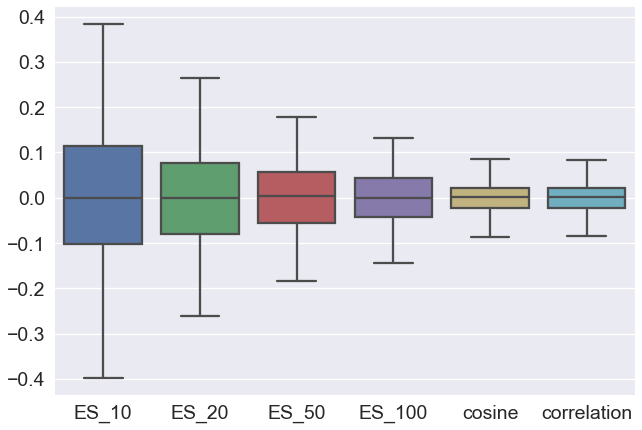

In [14]:
sns.boxplot(all_scores_df)

# Read gold standard of drug MoAs

In [17]:
drug_moa_df = pd.read_csv('../../Repurposing_Hub_export.txt', sep='\t')
print drug_moa_df.shape
drug_moa_df.head()

(5628, 5)


,Name,MOA,Target,Id,Phase
0,A-317491,purinergic receptor antagonist,P2RX3,"BRD-K38019854-323-01-4, BRD-K38019854-001-01-6",Preclinical
1,A-33903,NaN,NaN,BRD-A40302156-001-01-9,Phase 2
2,A-366,histone lysine methyltransferase inhibitor,"EHMT1, EHMT2","BRD-K06182768-001-02-3, BRD-K06182768-001-01-5...",Preclinical
3,A-674563,AKT inhibitor,"AKT1, PKIA, PRKACA",BRD-K78177893-001-02-4,Preclinical
4,A-7,calmodulin antagonist,NaN,BRD-K03301001-003-02-5,Preclinical


In [21]:
drug_moa_df['pert_ids'] = drug_moa_df['Id']\
    .map(lambda x: ','.join(set(['-'.join(item.split('-')[0:2]) for item in x.split(', ')])))

drug_moa_df['pert_id_count'] = drug_moa_df['pert_ids']\
    .map(lambda x: len(x.split(',')))

drug_moa_df['pert_id_count'].value_counts()

1    5179
2     359
3      75
4      11
5       4
Name: pert_id_count, dtype: int64

In [22]:
drug_moa_df.query('pert_id_count > 1').head()

,Name,MOA,Target,Id,Phase,pert_id_count,pert_ids
7,abacavir,nucleoside reverse transcriptase inhibitor,NaN,"BRD-A95032015-065-01-2, BRD-K17443395-065-01-4",Launched,2,"BRD-A95032015,BRD-K17443395"
13,abiraterone-acetate,androgen biosynthesis inhibitor,CYP17A1,"BRD-K24048528-001-01-7, BRD-K16133773-001-01-9",Launched,2,"BRD-K24048528,BRD-K16133773"
26,acadesine,AMPK activator,NaN,"BRD-K53448858-001-07-0, BRD-K04797704-001-01-9",Phase 3,2,"BRD-K53448858,BRD-K04797704"
30,acarbose,glucosidase inhibitor,"AMY2A, GAA, MGAM, SI","BRD-A16444946-001-09-7, BRD-K01621533-001-01-1...",Launched,3,"BRD-K01621533,BRD-K44276885,BRD-A16444946"
34,aceclidine,acetylcholine receptor agonist,"CHRM1, CHRM2, CHRM3, CHRM4, CHRM5","BRD-A32673558-003-03-9, BRD-A32673558-001-02-5...",Launched,3,"BRD-K68075732,BRD-A80567352,BRD-A32673558"


In [23]:
for col in drug_moa_df.columns:
    print col, drug_moa_df[col].nunique()

Name 5628
MOA 1262
Target 2149
Id 5628
Phase 8
pert_id_count 5
pert_ids 5620


In [24]:
drug_moa_df.count()

Name             5628
MOA              5086
Target           4020
Id               5628
Phase            5627
pert_id_count    5628
pert_ids         5628
dtype: int64

In [25]:
drug_moa_df.set_index('Name', inplace=True)

In [26]:
# A dict from pert_id to name
d_pert_name = {}
for name, row in drug_moa_df.iterrows():
    for pert_id in row['pert_ids'].split(','):
        d_pert_name[pert_id] = name
print len(d_pert_name)

6172


# Load signature data and metadata from MongoDB

In [28]:
# CD signatures produced by Qiaonan 
client = MongoClient('mongodb://146.203.54.131:27017/')
coll = client['L1000CDS2']['cpcd-gse70138']

cur = coll.find({'pert_type': 'trt_cp'}, 
                {'sig_id':True,
                 'pert_id':True,
                 '_id':False
                })
meta_df = pd.DataFrame([doc for doc in cur]).set_index('sig_id')
print meta_df.shape
meta_df.head()

(117126, 1)


,pert_id
sig_id,
CPC001_HA1E_24H:BRD-A82329351:10.0,BRD-A82329351
CPC001_HA1E_24H:BRD-K02607075:10.0,BRD-K02607075
CPC001_HA1E_24H:BRD-A49906757:10.0,BRD-A49906757
CPC001_HA1E_24H:BRD-K85242180:10.0,BRD-K85242180
CPC001_HA1E_24H:BRD-K78844995:10.0,BRD-K78844995


In [29]:
meta_df['batch'] = meta_df.index.map(lambda x: x.split(':')[0])
print meta_df['batch'].nunique()

371


In [34]:
meta_df['batch_prefix'] = meta_df['batch'].map(lambda x:x.split('_')[0])
meta_df['cell_id'] = meta_df['batch'].map(lambda x:x.split('_')[1])
meta_df['time'] = meta_df['batch'].map(lambda x:x.split('_')[2])

In [30]:
meta_df['batch'].value_counts()

CPC015_A549_6H         360
CPC009_HEPG2_6H        360
CPC001_HCC515_6H       360
CPC003_PC3_24H         360
CPC018_A549_6H         360
CPC002_PC3_24H         360
CPC002_HCC515_6H       360
CPC004_HA1E_6H         360
CPC004_HEPG2_6H        360
CPC018_HT29_6H         360
CPC016_HT29_6H         360
CPC003_VCAP_6H         360
CPC004_MCF7_6H         360
CPC001_PC3_24H         360
CPC006_HCC515_6H       360
CPC009_A375_6H         360
CPC017_MCF7_6H         360
CPC001_PC3_6H          360
CPC009_HA1E_6H         360
CPC016_HEPG2_6H        360
CPC006_SKMEL1_6H       360
CPC002_PC3_6H          360
CPD002_MCF7_6H         360
CPC017_A375_6H         360
CPC006_HT29_6H         360
CPC009_A549_6H         360
CPC015_MCF7_6H         360
CPC006_MCF7_6H         360
CPC017_HEPG2_6H        360
CPC016_A375_6H         360
                      ... 
LJP007_HA1E_24H        138
LJP007_HCC515_24H      137
LJP009_HEPG2_24H       137
LJP005_HCC515_24H      135
LJP009_A375_24H        134
LJP006_LNCAP_3H        133
L

In [35]:
meta_df['batch_prefix'].value_counts()

CPC006    20953
CPC012     6082
CPC013     6014
CPC014     6004
CPC005     5345
CPC007     5226
CPC009     4670
CPC019     4592
CPC010     4561
CPC004     4301
CPC008     4292
CPC017     3942
CPC016     3942
CPC018     3937
CPC015     3930
LJP006     3836
CPC011     3816
CPC020     3529
CPC001     2871
CPC002     2867
CPC003     2862
LJP005     2603
CPD002     1438
CPD003     1433
CPD001     1077
LJP009     1005
LJP007     1003
LJP008      995
Name: batch_prefix, dtype: int64

In [31]:
meta_df['pert_id'].nunique()

5907

In [33]:
meta_df.query('batch == "CPC015_A549_6H"')['pert_id'].value_counts()

BRD-K32830106    1
BRD-K39733634    1
BRD-K64245000    1
BRD-A27887842    1
BRD-K15933101    1
BRD-A55913614    1
BRD-A06726973    1
BRD-A51714012    1
BRD-K07996107    1
BRD-A16332958    1
BRD-A58048407    1
BRD-K52662033    1
BRD-A35912562    1
BRD-A50675702    1
BRD-K09537769    1
BRD-K52397688    1
BRD-K25650355    1
BRD-K73589491    1
BRD-A65671304    1
BRD-A89175223    1
BRD-A13964793    1
BRD-K95921201    1
BRD-K70330367    1
BRD-A06352418    1
BRD-K76805682    1
BRD-K88429204    1
BRD-K00603606    1
BRD-A97701745    1
BRD-K68867920    1
BRD-K47869605    1
                ..
BRD-K81521265    1
BRD-A41304429    1
BRD-K45296539    1
BRD-A07440155    1
BRD-K34776109    1
BRD-K54771420    1
BRD-K34157611    1
BRD-K02581333    1
BRD-A17411484    1
BRD-K53987533    1
BRD-A50737080    1
BRD-A59174698    1
BRD-K59753853    1
BRD-K28183345    1
BRD-K46384212    1
BRD-K28168037    1
BRD-A10977446    1
BRD-A01346607    1
BRD-A48430263    1
BRD-A68930007    1
BRD-K25224017    1
BRD-K1303258

## Signature connectivity scores of same drug on 

1. **Same batch**: same (batch_prefix:cell_id)
2. **Different batch**: same cell_id, different batch_prefix

In [50]:
from itertools import combinations

In [65]:
res_same_batch = {
    'cosine': np.array([]),
    'corr': np.array([]),
    'ES50': np.array([]),
}

grouped = meta_df.groupby(['batch_prefix', 'cell_id', 'pert_id'])

c = 0
for group, sub_df in grouped:
#     print group, sub_df.shape

    if sub_df.shape[0] > 1:
        sig_ids = sub_df.index.tolist()
        # Retrieve signature matrix
        sig_mat = np.zeros((len(sig_ids), 978))
        for i, sig_id in enumerate(sig_ids): 
            doc = coll.find_one({'sig_id': sig_id}, {'_id':False, 'chdirLm':True})
            sig_mat[i] = doc['chdirLm']
            
        scores_cosine = pscore(sig_mat, cosine_sim)
        scores_corr = pscore(sig_mat, correlation)
        scores_es50 = pscore(sig_mat, lambda x, y: gsea_score(x, y, 50))
        
        res_same_batch['cosine'] = np.hstack((res_same_batch['cosine'], scores_cosine))
        res_same_batch['corr'] = np.hstack((res_same_batch['corr'], scores_corr))
        res_same_batch['ES50'] = np.hstack((res_same_batch['ES50'], scores_es50))
    c += 1
    if c % 100 == 0:
        print c, len(grouped)

100 79962
200 79962
300 79962
400 79962
500 79962
600 79962
700 79962
800 79962
900 79962
1000 79962
1100 79962
1200 79962
1300 79962
1400 79962
1500 79962
1600 79962
1700 79962
1800 79962
1900 79962
2000 79962
2100 79962
2200 79962
2300 79962
2400 79962
2500 79962
2600 79962
2700 79962
2800 79962
2900 79962
3000 79962
3100 79962
3200 79962
3300 79962
3400 79962
3500 79962
3600 79962
3700 79962
3800 79962
3900 79962
4000 79962
4100 79962
4200 79962
4300 79962
4400 79962
4500 79962
4600 79962
4700 79962
4800 79962
4900 79962
5000 79962
5100 79962
5200 79962
5300 79962
5400 79962
5500 79962
5600 79962
5700 79962
5800 79962
5900 79962
6000 79962
6100 79962
6200 79962
6300 79962
6400 79962
6500 79962
6600 79962
6700 79962
6800 79962
6900 79962
7000 79962
7100 79962
7200 79962
7300 79962
7400 79962
7500 79962
7600 79962
7700 79962
7800 79962
7900 79962
8000 79962
8100 79962
8200 79962
8300 79962
8400 79962
8500 79962
8600 79962
8700 79962
8800 79962
8900 79962
9000 79962
9100 79962
9200 799

69900 79962
70000 79962
70100 79962
70200 79962
70300 79962
70400 79962
70500 79962
70600 79962
70700 79962
70800 79962
70900 79962
71000 79962
71100 79962
71200 79962
71300 79962
71400 79962
71500 79962
71600 79962
71700 79962
71800 79962
71900 79962
72000 79962
72100 79962
72200 79962
72300 79962
72400 79962
72500 79962
72600 79962
72700 79962
72800 79962
72900 79962
73000 79962
73100 79962
73200 79962
73300 79962
73400 79962
73500 79962
73600 79962
73700 79962
73800 79962
73900 79962
74000 79962
74100 79962
74200 79962
74300 79962
74400 79962
74500 79962
74600 79962
74700 79962
74800 79962
74900 79962
75000 79962
75100 79962
75200 79962
75300 79962
75400 79962
75500 79962
75600 79962
75700 79962
75800 79962
75900 79962
76000 79962
76100 79962
76200 79962
76300 79962
76400 79962
76500 79962
76600 79962
76700 79962
76800 79962
76900 79962
77000 79962
77100 79962
77200 79962
77300 79962
77400 79962
77500 79962
77600 79962
77700 79962
77800 79962
77900 79962
78000 79962
78100 79962
7820

(53269,)


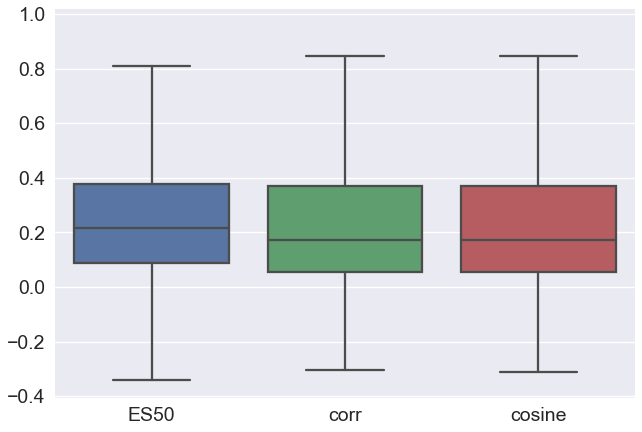

In [66]:
print res_same_batch['cosine'].shape
sns.boxplot(pd.DataFrame(res_same_batch))

In [78]:
res_diff_batch = {
    'cosine': np.array([]),
    'corr': np.array([]),
    'ES50': np.array([]),
}

grouped = meta_df.groupby(['cell_id', 'pert_id'])

c = 0
for group, sub_df in grouped:
    if sub_df.shape[0] > 1 and sub_df['batch_prefix'].nunique() > 1:
        sig_ids = sub_df.index.tolist()
        # Retrieve signature matrix
        sig_mat = np.zeros((len(sig_ids), 978))
        for i, sig_id in enumerate(sig_ids): 
            doc = coll.find_one({'sig_id': sig_id}, {'_id':False, 'chdirLm':True})
            sig_mat[i] = doc['chdirLm']
        
        # Compute scores
        scores_cosine = []
        scores_corr = []
        scores_es50 = []
        for i, j in combinations(range(len(sig_ids)), 2):
            if sub_df.iloc[i]['batch_prefix'] != sub_df.iloc[j]['batch_prefix']:
                # Not on the same batch
                scores_cosine.append(cosine_sim(sig_mat[i], sig_mat[j]))
                scores_corr.append(correlation(sig_mat[i], sig_mat[j]))
                scores_es50.append(gsea_score(sig_mat[i], sig_mat[j], 50))
                
        res_diff_batch['cosine'] = np.hstack((res_diff_batch['cosine'], np.array(scores_cosine)))
        res_diff_batch['corr'] = np.hstack((res_diff_batch['corr'], np.array(scores_corr)))
        res_diff_batch['ES50'] = np.hstack((res_diff_batch['ES50'], np.array(scores_es50)))

    c += 1
    if c % 100 == 0:
        print c, len(grouped)

100 72400
200 72400
300 72400
400 72400
500 72400
600 72400
700 72400
800 72400
900 72400
1000 72400
1100 72400
1200 72400
1300 72400
1400 72400
1500 72400
1600 72400
1700 72400
1800 72400
1900 72400
2000 72400
2100 72400
2200 72400
2300 72400
2400 72400
2500 72400
2600 72400
2700 72400
2800 72400
2900 72400
3000 72400
3100 72400
3200 72400
3300 72400
3400 72400
3500 72400
3600 72400
3700 72400
3800 72400
3900 72400
4000 72400
4100 72400
4200 72400
4300 72400
4400 72400
4500 72400
4600 72400
4700 72400
4800 72400
4900 72400
5000 72400
5100 72400
5200 72400
5300 72400
5400 72400
5500 72400
5600 72400
5700 72400
5800 72400
5900 72400
6000 72400
6100 72400
6200 72400
6300 72400
6400 72400
6500 72400
6600 72400
6700 72400
6800 72400
6900 72400
7000 72400
7100 72400
7200 72400
7300 72400
7400 72400
7500 72400
7600 72400
7700 72400
7800 72400
7900 72400
8000 72400
8100 72400
8200 72400
8300 72400
8400 72400
8500 72400
8600 72400
8700 72400
8800 72400
8900 72400
9000 72400
9100 72400
9200 724

69300 72400
69400 72400
69500 72400
69600 72400
69700 72400
69800 72400
69900 72400
70000 72400
70100 72400
70200 72400
70300 72400
70400 72400
70500 72400
70600 72400
70700 72400
70800 72400
70900 72400
71000 72400
71100 72400
71200 72400
71300 72400
71400 72400
71500 72400
71600 72400
71700 72400
71800 72400
71900 72400
72000 72400
72100 72400
72200 72400
72300 72400
72400 72400


In [81]:
print res_diff_batch['cosine'].shape

res_diff_batch = pd.DataFrame(res_diff_batch)
res_diff_batch.columns = res_diff_batch.columns.map(lambda x: x + ' diff batch')
res_same_batch = pd.DataFrame(res_same_batch)
res_same_batch.columns = res_same_batch.columns.map(lambda x: x + ' same batch')

                              
res_scores = pd.concat(
    [res_same_batch, res_diff_batch], 
    axis=1) 
print res_scores.shape
res_scores.count()


(33177,)
(53269, 6)


ES50 same batch      53269
corr same batch      53269
cosine same batch    53269
ES50 diff batch      33177
corr diff batch      33177
cosine diff batch    33177
dtype: int64

[None, None, None, None, None, None, None, None, None, None, None, None]

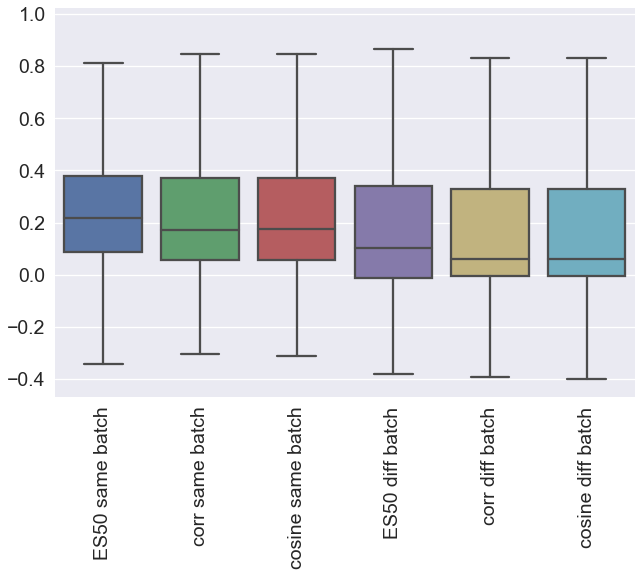

In [83]:
ax = sns.boxplot(pd.DataFrame(res_scores))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90);

In [84]:
res_scores.to_csv('data/same_drug_signature_connectivities_L1000CDS2.cpcd-gse70138.csv')